# Chicago simple voroni

For each "block" take the (weighted?) centroid.  Form the voroni diagram, and assign each block to its segment.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os, lzma, csv, bz2, io, collections, pickle
import pyproj
import tilemapbase
import shapely.geometry

import open_cp.sources.chicago

In [2]:
data_dir = os.path.join("/media", "disk", "Data")
data_dir = os.path.join("..", "..", "..", "..", "Data")
#os.listdir(data_dir)
filename = os.path.join(data_dir, "chicago_all.csv.xz")

In [3]:
with lzma.open(filename, "rt", encoding="utf8") as f:
    reader = csv.reader(f)
    header = next(reader)
    out = collections.defaultdict(list)
    data = []
    for row in reader:
        if row[15] == "":
            continue
        year = int(row[17])
        if year <= 2001:
            continue
        block, x, y = row[3], float(row[15]), float(row[16])
        x /= open_cp.sources.chicago._FEET_IN_METERS
        y /= open_cp.sources.chicago._FEET_IN_METERS
        if x < 10 or y < 10:
            continue
        out[block].append((x,y))
        data.append((block, x, y, row[5], row[6], row[7]))
out = {k : np.asarray(out[k]) for k in out}
len(out)

51625

## Find centroids

In [4]:
# Biased by distribution

centroids = {}
for k in out:
    x, y = out[k][:,0], out[k][:,1]
    centroids[k] = (np.mean(x), np.mean(y))

## Construct Veroni

In [1]:
import scipy.spatial

In [6]:
keys = list(centroids)
points = np.asarray([centroids[k] for k in keys])
voroni = scipy.spatial.Voronoi(points)

### Construct regions

This is slightly non-trivial.

In [7]:
def perp_direction(points, a, b):
    """Return (x,y) a vector which is pendicular to the line from point
    `a` to point `b` in `points`, orientated correctly, and of unit length.
    """
    x = points[b,0] - points[a,0]
    y = points[b,1] - points[a,1]
    n = np.sqrt(x*x + y*y)
    x, y = y/n, -x/n
    centre = np.mean(points, axis=0)
    midpoint = (points[a] + points[b]) / 2
    
    if np.dot(centre-midpoint, np.array([x,y])) <= 0:
        return x,y
    else:
        return -x,-y

In [17]:
inf_lines = {}
inf_dirs = {}
for ((a,b),(aa,bb)) in zip(voroni.ridge_vertices, voroni.ridge_points):
    if a == -1:
        sx, sy = voroni.vertices[b,0], voroni.vertices[b,1]
        x, y = perp_direction(voroni.points, aa, bb) 
        inf_dirs[b] = x, y
        inf_lines[b] = [sx, sx + x*2], [sy, sy + y*2]
    
voroni_polygons = []
for reg in voroni.regions:
    if len(reg) == 0:
        continue
    verts = [voroni.vertices[v] for v in reg]
    if -1 in reg:
        i = reg.index(-1)
        i_before, i_after = i-1, i+1
        if i_after == len(reg):
            i_after = 0
        i_before, i_after = reg[i_before], reg[i_after]
        xo, yo = voroni.vertices[i_after]
        xd, yd = inf_dirs[i_after]
        verts[i] = (xo+xd, yo+yd)
        #verts[i] = inf_lines[i_after][0][1], inf_lines[i_after][1][1]
        xo, yo = voroni.vertices[i_before]
        xd, yd = inf_dirs[i_before]
        verts.insert(i, (xo+xd, yo+yd))
        #verts.insert(i, (inf_lines[i_before][0][1], inf_lines[i_before][1][1]))
    voroni_polygons.append(verts)

In [18]:
import shapely.geometry

voroni_polygons = [shapely.geometry.Polygon(verts) for verts in voroni_polygons]

In [22]:
base = [[300, 525], [400,525], [400,625], [300,625]]
base = [[x*1000,y*1000] for x,y in base]
base = shapely.geometry.Polygon(base)

voroni_polygons = [verts.intersection(base) for verts in voroni_polygons]

In [28]:
voroni_polygons = [list(verts.exterior.coords) for verts in voroni_polygons]

[(564000, 566000), (359000, 361000)]

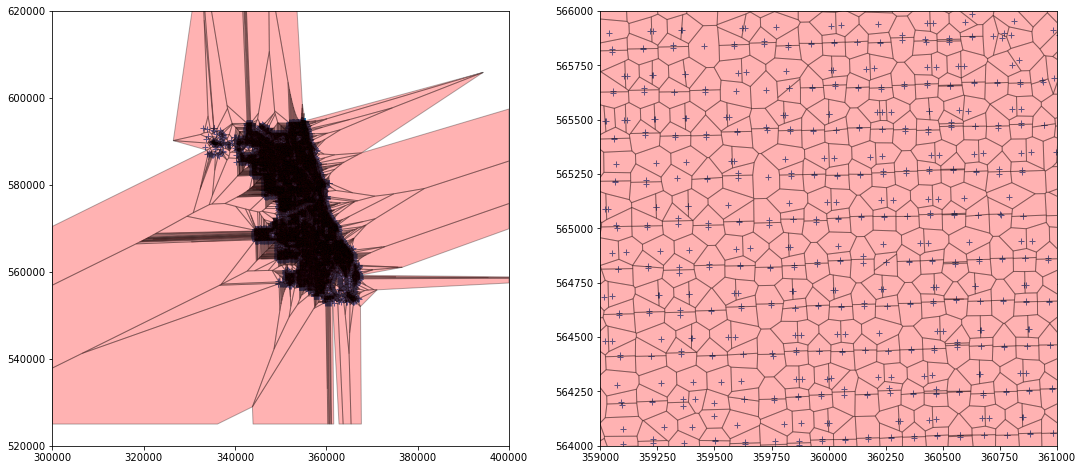

In [30]:
import matplotlib.patches

fig, axes = plt.subplots(ncols=2, figsize=(18,8))

for ax in axes:
    ax.scatter(*voroni.points.T, marker="+", linewidth=1)
    for i, verts in enumerate(voroni_polygons):
        poly = matplotlib.patches.Polygon(verts, fc="red", alpha=0.3, ec="black")
        ax.add_patch(poly)
        
x, y, s = 350000, 570000, 60000
axes[0].set(xlim=[x-s,x+s], ylim=[y-s,y+s])
x, y, s = 360000, 565000, 1000
axes[1].set(xlim=[x-s,x+s], ylim=[y-s,y+s])

[(585000, 605000), (340000, 360000)]

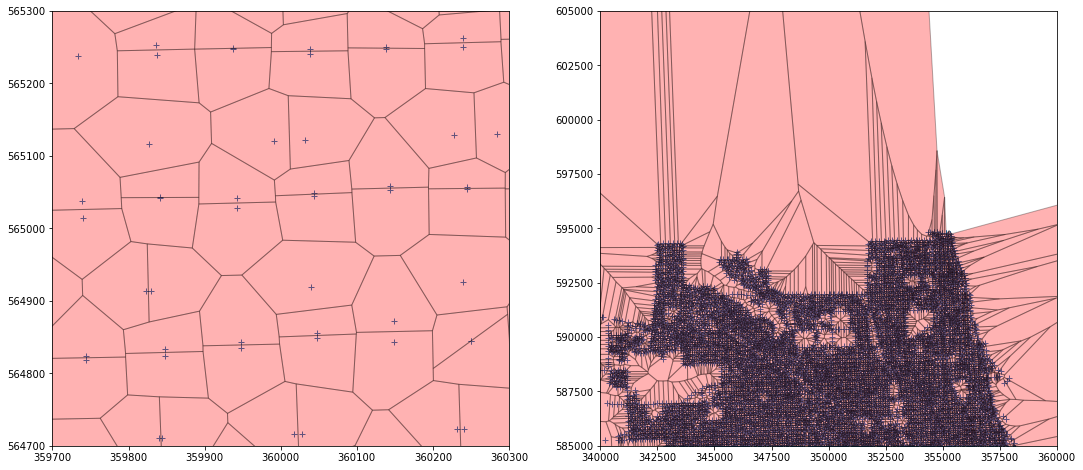

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(18,8))

for ax in axes:
    ax.scatter(*voroni.points.T, marker="+", linewidth=1)
    for i, verts in enumerate(voroni_polygons):
        poly = matplotlib.patches.Polygon(verts, fc="red", alpha=0.3, ec="black")
        ax.add_patch(poly)
        
x, y, s = 360000, 565000, 300
axes[0].set(xlim=[x-s,x+s], ylim=[y-s,y+s])
x, y, s = 350000, 595000, 10000
axes[1].set(xlim=[x-s,x+s], ylim=[y-s,y+s])

# Quick visualisation with a basemap

In [35]:
proj = pyproj.Proj({"init":"epsg:3528"})
voroni_polygons_tmb = []
for verts in voroni_polygons:
    verts1 = [proj(*v,inverse=True) for v in verts]
    verts2 = [tilemapbase.project(*v) for v in verts1]
    voroni_polygons_tmb.append(verts2)

points = []
for x, y in zip(*proj(*voroni.points.T, inverse=True)):
    x, y = tilemapbase.project(x, y)
    points.append((x,y))
points = np.asarray(points)

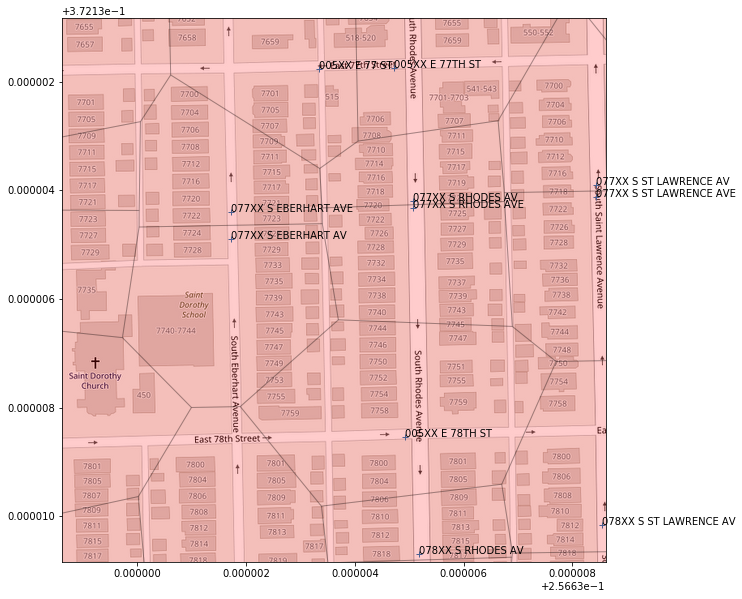

In [39]:
x, y = 360000, 565000
x, y = proj(x, y, inverse=True)

ex = tilemapbase.Extent.from_centre_lonlat(x, y, xsize=0.00001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=400)

fig, ax = plt.subplots(figsize=(10,10))
plotter.plot(ax)

ax.scatter(*points.T, marker="+", linewidth=1)
for i, verts in enumerate(voroni_polygons_tmb):
    poly = matplotlib.patches.Polygon(verts, fc="red", alpha=0.2, ec="black")
    ax.add_patch(poly)
    
for k in keys:
    x, y = centroids[k]
    x, y = tilemapbase.project(*proj(x, y,inverse=True))
    if x >= ex.xmin and x <= ex.xmax and y >= ex.ymin and y <= ex.ymax:
        ax.text(x, y, k)